## Problem Description:
This outlines a machine learning problem in which you are required to create a model that can discriminate between English, Afrikaans, and Dutch phrases. A labelled dataset of phrases is provided/attached (lang_data.csv).

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)


from sklearn.metrics import r2_score
from sklearn import model_selection
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn import metrics

from sklearn.feature_extraction.text import CountVectorizer ,TfidfTransformer

import inflect
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import re
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

import pickle

# download stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
# load data 
df = pd.read_csv("../data/lang_data.csv")
len(df)

2839

In [25]:
# check if there are null
print('{} phrases are null'.format(df.isnull().text.sum()))
df[df.isnull().text]

78 phrases are null


,text,language
7,NaN,Afrikaans
11,NaN,Afrikaans
17,NaN,Afrikaans
51,NaN,Nederlands
70,NaN,English
...,...,...
2639,NaN,Nederlands
2660,NaN,Afrikaans
2676,NaN,Nederlands
2802,NaN,English


### First we going to drop the NAN values

In [4]:
# looks like there are some nulls so drop them
df = df.dropna(how='any')

In [5]:
# show the random 10 samples from the data frame
df.sample(10)

,text,language
2658,Lark about,English
1304,Smart casual,English
615,Stiff upper lip,English
1444,Pull the wool over your eyes,English
2552,Jump the gun,English
1758,Bottle out,English
1881,Carpe Diem: Gryp die dag!,Afrikaans
412,Faint-hearted,English
155,Rumpy-pumpy,English
2216,The dark side,English


Text(0, 0.5, 'Number of Phrases')

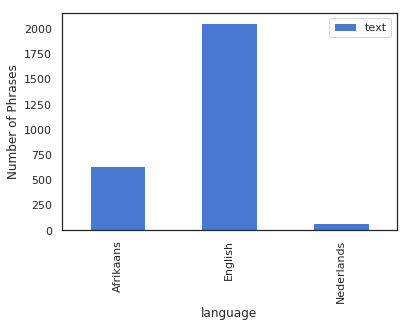

In [20]:
ax = df.groupby('language').count().plot.bar()
ax.set_ylabel('Number of Phrases')

## Looks like there is a big class imbalance 

# Data analysis and mining


In [7]:
# see a quick summary of the data
df.describe()

,text,language
count,2761,2761
unique,2752,3
top,For all intents and purposes,English
freq,2,2055


### Clean up the text:

In [8]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words, language='english'):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer(language)
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words,language='english'):
    """ Run all cleaning steps"""
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = stem_words(words, language)
    return words

In [9]:
df_clean = df.text.str.split(' ').apply(normalize).apply(lambda s: ' '.join(s))

In [10]:
# check that pre-processing is working
vectorizer = CountVectorizer()
vectorizer.fit(df_clean)
print(vectorizer.get_feature_names())

['1500s', '1ste', 'a1', 'aa', 'aagg', 'aalwyn', 'aalwynpil', 'aan', 'aanbod', 'aanbrandsel', 'aandkla', 'aandui', 'aangenam', 'aangesigt', 'aangewaai', 'aanja', 'aankom', 'aankweek', 'aanlê', 'aanpasbaarheid', 'aansien', 'aansit', 'aanslag', 'aanspreek', 'aantrekken', 'aanvraag', 'aap', 'aard', 'aartappel', 'aasdieromslagtigheid', 'aback', 'abandon', 'abet', 'abid', 'abl', 'abracadabra', 'absenc', 'absent', 'absolut', 'absorb', 'accid', 'accident', 'accompli', 'accord', 'ace', 'achiev', 'achill', 'achterklap', 'acid', 'acorn', 'acquaint', 'acronym', 'across', 'act', 'action', 'adam', 'ado', 'adr', 'af', 'afbreek', 'afdraand', 'afhaal', 'afkam', 'afklim', 'afklink', 'afkophoend', 'afoot', 'afpoeier', 'afpraat', 'afraid', 'afsaal', 'afternoon', 'aftre', 'aga', 'age', 'agenda', 'agi', 'agog', 'agre', 'agter', 'agterbeen', 'agterdeur', 'agterdeursuip', 'agterlaat', 'agterpot', 'agterstevoor', 'agteruitgaan', 'aid', 'aidemémoir', 'aint', 'air', 'akimbo', 'akker', 'al', 'ala', 'albatross', '

In [11]:
classes = df[['language']].replace(['English','Afrikaans','Nederlands'], [0, 1, 2])

In [12]:
data_frame = classes.join(df_clean)
data_frame.head(10)

,language,text
0,0,ship shape bristol fashion
1,0,know rope
2,0,graveyard shift
3,0,milk human kind
4,0,touch bargepol wouldnt
5,1,sy kan altyd batteri natpiepi
6,0,shit hit fan
8,0,egg
9,0,drag race
10,0,queer nine bob note


### Split the data to training and test dataset 
To validate the classifier against unseen data, we can just split the training set into two parts with a ratio of 2:8 

In [13]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(data_frame['text'],data_frame['language'], test_size=0.2, random_state=0)

In [65]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

# Try SVM Model:
Let's try Stochastic Gradient Descent classifier with loss 'hinge', which is an SVM model,  and see how it is going to work

In [31]:
sgd_clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty='l2',class_weight="balanced")),])
# train the model on the 80% of the data, the training dataset 
sgd_clf = sgd_clf.fit(X_train, Y_train)

CV F1 score: 0.972 +/- 0.008
[[409   1   1]
 [  5 124   1]
 [  1   1  10]]


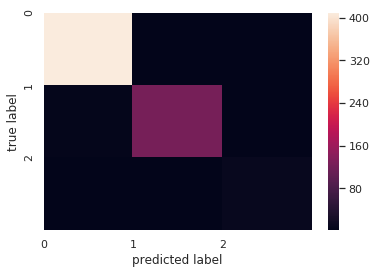

In [69]:
# check how the 
predicted = sgd_clf.predict(X_test)
np.mean(predicted == Y_test)    
kfold = model_selection.StratifiedKFold(n_splits=5)
scores = model_selection.cross_val_score(estimator=sgd_clf,
                         X=X_train,
                         y=Y_train,
                         cv=kfold, scoring='f1_weighted')
print( "=========================================")
print('CV F1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
print( "=========================================")



### Check how the model perform using the confusion matrix 

predicted_Y=sgd_clf.predict(X_test)
test_results = confusion_matrix(Y_test.values, predicted_Y,labels=[0,1,2])
print( test_results)
sns.heatmap(test_results)
no_tickers = np.arange(3)
plt.xticks(no_tickers)
plt.yticks(no_tickers)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

### Other evaluation matrices 

In [70]:
print(classification_report(Y_test, predicted_Y, target_names=['English','Afrikaans', 'Dutch']))

              precision    recall  f1-score   support

     English       0.99      1.00      0.99       411
   Afrikaans       0.98      0.95      0.97       130
       Dutch       0.83      0.83      0.83        12

    accuracy                           0.98       553
   macro avg       0.93      0.93      0.93       553
weighted avg       0.98      0.98      0.98       553



### Debugging algorithms with learning and validation curves

In [40]:
train_sizes, train_scores, test_scores = model_selection.learning_curve(estimator=sgd_clf,
                                                        X=X_train,
                                                        y=Y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10)

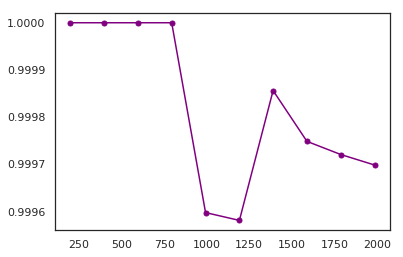

In [41]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='purple', marker='o', markersize=5,label='training accuracy')

### Is there over fitting?

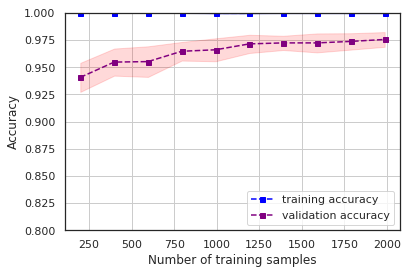

In [42]:
plt.plot(train_sizes, train_mean, color='blue', linestyle='--', marker='s', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='purple', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='red')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()
# I won't worry much about the differences..

## Tuning the model hyperparameters

In [53]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': [0.0001, 0.001, 0.01, 0.1],
                "clf__penalty" : ["l2", "l1", "none"],
             'clf__loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']}

In [55]:
gs_clf = model_selection.GridSearchCV(sgd_clf, parameters, n_jobs=-1)

In [56]:
gs_clf = gs_clf.fit(X_train, Y_train)

In [57]:
gs_clf.best_estimator_

Pipeline(steps=[('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf',
                 SGDClassifier(alpha=0.1, class_weight='balanced',
                               loss='perceptron'))])

In [58]:
gs_clf.best_score_ 

0.9764541714121545

553
[[408   3   0]
 [  5 124   1]
 [  3   2   7]]


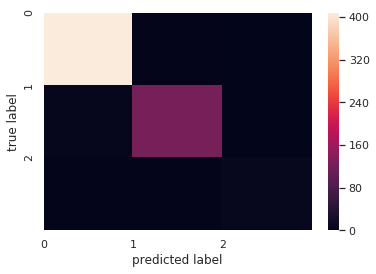

In [51]:
### Check how the model perform using the confusion matrix 
print( len(X_test))
predicted_Y=gs_clf.best_estimator_.predict(X_test)
test_results = confusion_matrix(Y_test.values, predicted_Y,labels=[0,1,2])
print( test_results)
sns.heatmap(test_results)
no_tickers = np.arange(3)
plt.xticks(no_tickers)
plt.yticks(no_tickers)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()


# Undersample the majority class to investigate the imbalance in the classes

In [72]:
contain_Nederlands  = data_frame[data_frame.language==2]
print( len(contain_Nederlands[contain_Nederlands==True]))

67


In [73]:
contain_English = data_frame[data_frame.language==0][:100]
print( len(contain_English[contain_English==True]))

100


In [74]:
contain_Afrikaans = data_frame[data_frame.language==1][:100]
print( len(contain_Afrikaans[contain_Afrikaans==True]))

100


In [75]:
# create the 
undersampled_df  = contain_English.append(contain_Afrikaans.append(contain_Nederlands))
print (len(undersampled_df))

267


In [81]:
X_train_US, X_test_US, Y_train_US, Y_test_US = model_selection.train_test_split(undersampled_df['text'],undersampled_df['language'], test_size=0.5, random_state=0)

In [82]:
undersampled_df.isnull().sum()

language    0
text        0
dtype: int64

# redo the model, tune the model and the evaluation, for the the undersampled (english class) data frame. 

[[51  1  0]
 [ 3 43  5]
 [ 8  1 22]]


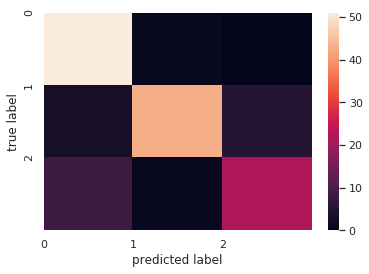

CV F1 score: 0.891 +/- 0.068


In [95]:
from sklearn.linear_model import SGDClassifier
sgd_clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='perceptron', penalty='l2',alpha=0.1, class_weight="balanced", random_state=0)),])
_ = sgd_clf.fit(X_train_US, Y_train_US)
predicted = sgd_clf.predict(X_test_US)
np.mean(predicted == Y_test_US)    

### Check how the model perform using the confusion matrix 

predicted_Y=sgd_clf.predict(X_test_US)
test_results = confusion_matrix(Y_test_US.values, predicted_Y,labels=[0,1,2])
print( test_results)
sns.heatmap(test_results)
no_tickers = np.arange(3)
plt.xticks(no_tickers)
plt.yticks(no_tickers)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

#preform cross validation using 5 folds
kfold = model_selection.StratifiedKFold()
scores_US = model_selection.cross_val_score(estimator=sgd_clf,
                         X=X_train_US,
                         y=Y_train_US,
                         cv=kfold, scoring='f1_weighted')
print( "=========================================")
print('CV F1 score: %.3f +/- %.3f' % (np.mean(scores_US),
                                      np.std(scores_US)))
print ("=========================================")

## Tuning the model hyperparameters

Pipeline(steps=[('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf',
                 SGDClassifier(alpha=0.001, class_weight='balanced', loss='log',
                               penalty='none', random_state=0))])
0.9401709401709402
[[51  1  0]
 [ 3 43  5]
 [ 8  1 22]]


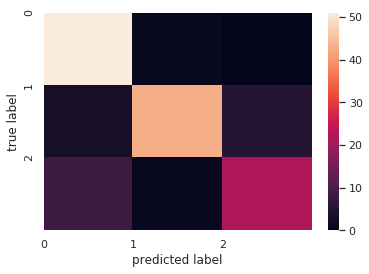

In [84]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': [0.0001, 0.001, 0.01, 0.1],
                "clf__penalty" : ["l2", "l1", "none"],
             'clf__loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']}
gs_clf = model_selection.GridSearchCV(sgd_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train_US, Y_train_US)
print( gs_clf.best_estimator_)
print( gs_clf.best_score_ )
### Check how the model perform using the confusion matrix 

predicted_Y_US=gs_clf.best_estimator_.predict(X_test_US)
test_results = confusion_matrix(Y_test_US.values, predicted_Y,labels=[0,1,2])
print( test_results)
sns.heatmap(test_results)
no_tickers = np.arange(3)
plt.xticks(no_tickers)
plt.yticks(no_tickers)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [94]:
gs_clf.predict(X_test_US)

array([1, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2,
       0, 0, 1, 1, 1, 2, 1, 2, 1, 2, 0, 1, 0, 1, 2, 0, 2, 0, 2, 1, 0, 2,
       1, 0, 0, 1, 0, 0, 1, 2, 0, 2, 1, 1, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 2, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 2, 1, 0, 0, 0, 1, 0, 0, 2, 2, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       2, 0])

In [85]:
print(classification_report(Y_test_US, predicted_Y_US, target_names=['English','Afrikaans', 'Dutch']))

              precision    recall  f1-score   support

     English       0.86      0.98      0.92        52
   Afrikaans       0.94      0.96      0.95        51
       Dutch       0.96      0.71      0.81        31

    accuracy                           0.91       134
   macro avg       0.92      0.88      0.90       134
weighted avg       0.92      0.91      0.91       134



# Save the model 

In [72]:
filename = '../models/lang_class_final_svm_model.sav'
pickle.dump(gs_clf.best_estimator_, open(filename, 'wb'))

In [32]:
#loaded_model = pickle.load(open(filename, 'rb'))
#loaded_model.predict(X_test)